Since CoxPH model does not work well on our data:
- not good prediction (constant).
- does not capture non-linear relationships well.
we are going to use another model, which is based on Random Forests. But is adapted to the context of Survival Anlaysis. Namely Random Survival Forest (RSF).

# Data Pre-processing

--> RF:
- can work with IMbalanced data. (https://ieeexplore.ieee.org/abstract/document/8122151)
- no feature selection: RF can handle high dimensional data without feature selection.
- can handle multicollinearity well. (no deletion of MaximumAbsoluteVibration.mean needed)

### Data preparation algorithm

In [13]:
import pandas as pd

def aggregate_data(data):
   
    # deletes "Time" column, since we only use ReadableDate
    data = data.drop('Time', axis=1)
    
    # AGGREGATION:
    # sets 'ReadableDate' as the index
    data.set_index('ReadableDate', inplace=True)

    # resamples the DataFrame to hourly intervals and aggregates using mean, std, max, min. 
    # use 'MAX' for breakdown, so that if there is a breakdown during the hour, the aggregated data is also labelled 1.
    data = data.resample('H').agg({'RMSVibration.mean': ['mean', 'std', 'max', 'min'], 'Temperature.mean': ['mean', 'std', 'max', 'min'], 'SpeedPeak.mean': ['mean', 'std', 'max', 'min'], 'Kurtosis.mean': ['mean', 'std', 'max', 'min'], 'MaximumAbsoluteVibration.mean': ['mean', 'std', 'max', 'min'], 'RMSAcceleration.mean': ['mean', 'std', 'max', 'min'], 'Skewness.mean': ['mean', 'std', 'max', 'min'], 'Breakdown': 'max'})
    
    # flattens the multi-level column names. So that for each feature, we get 4 separate aggreagted feature columns.
    data.columns = ['_'.join(col).strip() for col in data.columns.values]
    
    if 'Breakdown_max' in data.columns:
        # rename the column again to 'Breakdown'
        data.rename(columns={'Breakdown_max': 'Breakdown'}, inplace=True) # otherwise a lot of code needs to be changed.
    # resets index to make 'ReadableDate' a column again
    data.reset_index(inplace=True)

    # checks missing values
    missing_indices = data[data.isnull().any(axis=1)].index

    # missing rows are the result of cleanings during the WHOLE hour, and are deleted. So these missing values can be also deleted
    data.drop(missing_indices, inplace=True)
    
    # resets indices
    data.reset_index(drop=True, inplace=True)

    return data

    

def prepare_data(data, window_size, num_lags):
    
    # FEATURE CREATION:
    window_size = window_size  # HYPERPARAMETER !!
    num_lags = num_lags  # HYPERPARAMETER !!
    cols = data.columns.difference(['ReadableDate', 'Breakdown', 'Active'])

    for column in cols:
        # rolling statistics
        data[f'{column}_RollingMean'] = data[column].rolling(window=window_size, min_periods=1).mean()
        data[f'{column}_RollingStd'] = data[column].rolling(window=window_size, min_periods=1).std()
        data[f'{column}_RollingMin'] = data[column].rolling(window=window_size, min_periods=1).min()
        data[f'{column}_RollingMax'] = data[column].rolling(window=window_size, min_periods=1).max()
        # std needs at least 2 observations, but since otherwise we have to delete entire row, we set first Std to 0.
        data.loc[0, f'{column}_RollingStd'] = 0
    
        # lag features
        for lag in range(1, num_lags + 1):
            data[f'{column}_Lag_{lag}'] = data[column].shift(lag)
    
    # drops rows with NaN values resulting from the shift operation (LAGS, first #lags rows have NaN value(s)) 
    data.dropna(inplace=True)
    # resets indices
    data.reset_index(drop=True, inplace=True)


    return data
    

### "Active" algorithm
--> calculates the "lifetime" of each instance.

In [7]:
import pandas as pd

def calculate_active_duration(total_data):
     
    # initializes variables 'last_active_value' & 'breakdown_end_date'
    last_active_value = None
    breakdown_end_date = pd.Timestamp('8/31/2022 12:05:20 PM')  # initialization based on justifications 08/2022
    
    # iterates over the DataFrame to calculate the number of days since the previous breakdown
    # first we did not have the breakdown_end_date (because we did not have access to the justifications file from August 2022), therefore there are some ifs that contain: 'if breakdown_end_data is None'.    
    for i in range(len(total_data)):
        if total_data.loc[i, 'Breakdown'] == 0:
            if breakdown_end_date is None:
                total_data.loc[i, 'Active'] = 0
            else:
                days_since_last_breakdown = (total_data.loc[i, 'ReadableDate'] - breakdown_end_date).days
                total_data.loc[i, 'Active'] = days_since_last_breakdown
        else:
            last_active_value = total_data.loc[i, 'ReadableDate']
            if last_active_value is not None and breakdown_end_date is not None:
                days_since_last_breakdown = (last_active_value - breakdown_end_date).days
                total_data.loc[i, 'Active'] = days_since_last_breakdown
            else:
                total_data.loc[i, 'Active'] = 0

        if total_data.loc[i, 'Breakdown'] == 1 and (i == len(total_data) - 1 or total_data.loc[i + 1, 'Breakdown'] == 0):
            breakdown_end_date = total_data.loc[i, 'ReadableDate']
            total_data.loc[i + 1, 'Active'] = 0
            
    
    return total_data


# Data processing

In [ ]:
# reads data to dataframe
df = pd.read_excel("/Users/wardmestdagh/Documents/HIRB/THESIS/DOCUMENTEN PURATOS/SENSOR DATA/sensor_breakdown_label_elim.xlsx")

# aggregate data to hourly basis
data_agg = aggregate_data(df)

# data.to_excel("/Users/wardmestdagh/Documents/HIRB/THESIS/DOCUMENTEN PURATOS/SENSOR DATA/aggregated_data.xlsx", index=False)

data = calculate_active_duration(data_agg)

# splits the data in train/val/test sets:
    # Since we split CoxPH with a 70/15/15, we want to do the same split. But because we first aggregate the data (and not every hour has the same amount of observations, since the sensorreading frequency is not constant). 
    # So if we want the same 70/15/15 split (that was conducted) on the raw data, we will need to use the split dates that correspond with the 70/15/15 split of the CoxPH model.
    # This will result in more comparable results, and corresponds actually tp a 70/15/15 split on the raw unaggregated data
    # Obtain the split dates (that were used in the CoxPH model approach, to obtain comparable split)
split_date1 = pd.Timestamp ('2023-03-07 21:00:00') 
split_date2 =  pd.Timestamp('2023-04-22 09:00:00')
print(split_date1)
print(split_date2)

    # splits the data into train, validation, and test sets based on the split dates
train_split = data[data['ReadableDate'] < split_date1]
validation_split = data[(data['ReadableDate'] >= split_date1) & (data['ReadableDate'] < split_date2)]
test_split = data[data['ReadableDate'] >= split_date2]


# feature engineering after the split otherwise we can have data leakage (via the rolling windows & lags)
final_train = prepare_data(train_split, 50, 7)
final_validation = prepare_data(validation_split, 50, 7)
final_test = prepare_data(test_split, 50, 7)

#final_train.to_excel("/Users/wardmestdagh/Documents/HIRB/THESIS/DOCUMENTEN PURATOS/SENSOR DATA/final_train.xlsx", index=False)

### Hyperparameter tuning
--> optimizing the hyperparamters of the RSF. We do this on a data set with no lags and no rollingstatistics. 

--> num_lags & window_size will be optimized after the model parameters are optimized. 

In [26]:
import numpy as np
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

X_train = final_train.drop(columns=['ReadableDate','Breakdown', 'Active'])  # features for training
Y_train = final_train[['Breakdown', 'Active']]  # event label and  lifetime for training

X_val = final_validation.drop(columns=['ReadableDate', 'Breakdown', 'Active'])  # features for validating
Y_val = final_validation[['Breakdown', 'Active']]  # event label and  lifetime for validating

# converts target (Y) data to structured array (this is needed for the RSF)
Y_train_structured = np.array([(e, t) for e, t in zip(Y_train['Breakdown'], Y_train['Active'])],
                              dtype=[('Breakdown', '?'), ('Active', '<f8')])
Y_val_structured = np.array([(e, t) for e, t in zip(Y_val['Breakdown'], Y_val['Active'])],
                             dtype=[('Breakdown', '?'), ('Active', '<f8')])


# instantiates the Random Survival Forest (RSF) model
rsf = RandomSurvivalForest()

# defines the parameter grid to search
param_grid = {'n_estimators': list(range(50, 401, 10)), 
              'max_features': ['sqrt', 'log2'],
              'min_samples_split': list(range(2, 13)),
              'n_jobs': [-1], 'random_state': [42]}


# creates ParameterGrid object
param_grid = ParameterGrid(param_grid)

# performs the grid search
best_score = float('-inf')
best_params = None
for i, params in enumerate(param_grid, start=1):
    
    # updates the model parameters 
    rsf.set_params(**params)
    
    # fits the model to the training data
    rsf.fit(X_train, Y_train_structured)
    
    # evaluates the model on validation data (by calculating the c-index)
    score = rsf.score(X_val, Y_val_structured)
    

    print(f"Iteration {i}/{len(param_grid)} - Parameters: {params}, Score: {score}")

    # updates best parameters if current score (c-index) is better
    if score > best_score:
        best_score = score
        best_params = params

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Iteration 1/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 42}, Score: 0.6639746178252092
Iteration 2/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 60, 'n_jobs': -1, 'random_state': 42}, Score: 0.6654167868474186
Iteration 3/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 70, 'n_jobs': -1, 'random_state': 42}, Score: 0.6408278050187481
Iteration 4/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 80, 'n_jobs': -1, 'random_state': 42}, Score: 0.7083213152581482
Iteration 5/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 90, 'n_jobs': -1, 'random_state': 42}, Score: 0.722094029420248
Iteration 6/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}, Score: 0.7281511393135276
Iteration 7/792 - Parameters: {'max_feat

We have determined the optimal parameters for the model, but we still need to determine the values for the num_lags and window_size hyperparameters. We will optimize these by manually experimenting with different values and evaluating their impact on the c-index using the RSF model with the already optimized parameters.

In [8]:
X_train = final_train.drop(columns=['ReadableDate','Breakdown', 'Active'])  # features for training
Y_train = final_train[['Breakdown', 'Active']]  # event label and  lifetime for training

X_val = final_validation.drop(columns=['ReadableDate', 'Breakdown', 'Active'])  # features for validating
Y_val = final_validation[['Breakdown', 'Active']]  # event label and lifetimetime for validating

# converts target (Y) data to structured array (this is needed for the RSF)
Y_train_structured = np.array([(e, t) for e, t in zip(Y_train['Breakdown'], Y_train['Active'])],
                              dtype=[('Breakdown', '?'), ('Active', '<f8')])
Y_val_structured = np.array([(e, t) for e, t in zip(Y_val['Breakdown'], Y_val['Active'])],
                             dtype=[('Breakdown', '?'), ('Active', '<f8')])



rsf2 = RandomSurvivalForest(**best_params)
rsf2.fit(X_train, Y_train_structured)

# evaluates the model on validation data (by calculating the c-index)
test_cindex = rsf2.score(X_val, Y_val_structured)


print("\Test Set Performance:")
print("Concordance Index:", test_cindex)

\Test Set Performance:
Concordance Index: 0.9901134050596103


First we optimize window_size (holding num_lags = 0):
| window_size | C-Index |
|-------------|---------|
| 0           | 0.845   |
| 5           | 0.538   |
| 10          | 0.724   |
| 15          | 0.656   |
| 20          | 0.669   |
| 25          | 0.534   |
| 30          | 0.613   |
| 35          | 0.642   |
| 40          | 0.691   |
| 45          | 0.817   |
| 50          | **0.971**   |
| 55          | 0.934   |
| 60          | 0.895   |

We know use the result of the optimized window_size (50) to optimize the num_lags:
| n_lags | C-Index |
|--------|---------|
| 1      | 0.971   |
| 2      | 0.959   |
| 3      | 0.971   |
| 4      | 0.961   |
| 5      | 0.974   |
| 6      | 0.981   |
| 7      | **0.990**   |
| 8      | 0.963   |
| 9      | 0.977   |
| 10     | 0.969   |

-> **Optimal parameters (window_size, num_lags) = (50, 7)**

### Feature importances
source importances: https://scikit-survival.readthedocs.io/en/stable/user_guide/random-survival-forest.html

In [88]:
from sklearn.inspection import permutation_importance

# trains the model (with best hyperparamters)
model = RandomSurvivalForest(**best_params)
model.fit(X_train, Y_train_structured)

# evaluates on validation set by computing the c-index
val_pred = model.predict(X_val)
print(Y_val_structured)
val_cindex = model.score(X_val, Y_val_structured)


print("\nValidation Set Performance:")
print("Concordance Index:", val_cindex)


# computes feature importance
result = permutation_importance(model, X_val, Y_val_structured, n_repeats=15, random_state=20)

# creates dataframe, which can later be used to print the results
importance_df = pd.DataFrame({
    "Feature": X_val.columns,
    "Importance Mean": result.importances_mean,
    "Importance Std": result.importances_std
}).sort_values(by="Importance Mean", ascending=False)

# prints dataframe
print(importance_df)
#importance_df.to_excel("/Users/wardmestdagh/Documents/HIRB/THESIS/DOCUMENTEN PURATOS/SENSOR DATA/importances.xlsx", index=False)

[(False, 50.) (False, 50.) (False, 50.) ... (False,  4.) (False,  4.)
 (False,  4.)]

Validation Set Performance:
Concordance Index: 0.9901134050596103
                                           Feature  Importance Mean  \
105  MaximumAbsoluteVibration.mean_std_RollingMean         0.052346   
174              RMSVibration.mean_mean_RollingMax         0.006349   
283                  SpeedPeak.mean_std_RollingMin         0.003800   
18               MaximumAbsoluteVibration.mean_max         0.003606   
163               RMSVibration.mean_max_RollingMax         0.002297   
..                                             ...              ...   
109        MaximumAbsoluteVibration.mean_std_Lag_1        -0.002520   
207                   Skewness.mean_max_RollingMax        -0.002985   
216                  Skewness.mean_mean_RollingStd        -0.003102   
50                   Kurtosis.mean_min_RollingMean        -0.003179   
149           RMSAcceleration.mean_std_RollingMean        -0.004968

### Model training & testing
Trian model on both train and validation set. Than test it on test set. (https://datascience.stackexchange.com/questions/55374/is-it-correct-to-join-training-and-validation-set-before-inferring-on-test-set#:~:text=Yes%2C%20once%20you%20optimized%20your,subset%20of%20the%20training%20set.)

In [9]:
# we combine the train & validation sets, so that the model incorporates as much information as possible.
X_train_final = (pd.concat([final_train, final_validation], ignore_index=True)).drop(columns=['ReadableDate','Breakdown', 'Active']) # features for training
Y_train_final = (pd.concat([final_train, final_validation], ignore_index=True))[['Breakdown', 'Active']]  # event label and  lifetime for training

X_test = (final_test.drop(columns=['ReadableDate', 'Breakdown', 'Active'])) # features for validating
Y_test = final_test[['Breakdown', 'Active']]  #  event label and  lifetime for validating

# converts target (Y) data to structured array (this is needed for the RSF)
Y_train_final_structured = np.array([(e, t) for e, t in zip(Y_train_final['Breakdown'], Y_train_final['Active'])],
                              dtype=[('Breakdown', '?'), ('Active', '<f8')])
Y_test_structured = np.array([(e, t) for e, t in zip(Y_test['Breakdown'], Y_test['Active'])],
                              dtype=[('Breakdown', '?'), ('Active', '<f8')])


# trains the model (with best parameters)
RSF = RandomSurvivalForest(**best_params)
RSF.fit(X_train_final, Y_train_final_structured)

# evaluates performance on test set, by computing the c-index
test_cindex = RSF.score(X_test, Y_test_structured)

print("\Test Set Performance:")
print("Concordance Index:", test_cindex)


\Test Set Performance:
Concordance Index: 0.4872585285655569


In [10]:
import numpy as np

# array of the predicted survival functions of each instance in the test set
survival_probs_array = RSF.predict_survival_function(X_test, return_array=False)
rul_estimates = []

# iterates through each survival function
for survival_function in survival_probs_array:
    # integrates the survival function to compute the expected RUL (using the Trapezoidal rule)
    rul_estimate = np.trapz(survival_function.y, survival_function.x)
    rul_estimates.append(rul_estimate)

# displays the estimated RUL for each instance in the test set
print("Estimated RUL for each instance in the test set:")
for i, rul in enumerate(rul_estimates):
    print(f"Instance {i}: {rul}")


Estimated RUL for each instance in the test set:
Instance 0: 55.44999999999999
Instance 1: 56.26
Instance 2: 58.809999999999995
Instance 3: 57.662000000000006
Instance 4: 57.56571428571429
Instance 5: 58.570000000000014
Instance 6: 59.580000000000005
Instance 7: 57.95349206349208
Instance 8: 59.809999999999995
Instance 9: 59.01
Instance 10: 60.32499999999999
Instance 11: 59.92499999999998
Instance 12: 59.45600000000001
Instance 13: 58.141999999999996
Instance 14: 58.34380952380951
Instance 15: 57.389
Instance 16: 59.43000000000001
Instance 17: 60.31000000000001
Instance 18: 55.48380952380951
Instance 19: 59.63000000000002
Instance 20: 58.535
Instance 21: 57.79380952380952
Instance 22: 59.46
Instance 23: 59.37000000000001
Instance 24: 58.970000000000006
Instance 25: 60.44
Instance 26: 60.760000000000005
Instance 27: 61.07999999999999
Instance 28: 61.25000000000001
Instance 29: 61.61999999999999
Instance 30: 61.52999999999999
Instance 31: 61.58
Instance 32: 61.47666666666667
Instance 33:

In [11]:
# make a dataframe with predictions (this will later be used to plot the True RUl against the predicted RUL)
test_result = final_test[["ReadableDate", "Breakdown", "Active"]].copy()
test_result["RUL_prediction"] = rul_estimates

### Plot (True_RUL vs Predicted_RUL)

In [12]:
# ReadableDate of each breakdwon in the test set
breakdown_times = test_result[test_result['Breakdown'] == 1]['ReadableDate']

True_RUL = []
# computes the True_RUL
for index, row in test_result.iterrows():
    if not breakdown_times.empty and breakdown_times.iloc[0] == row['ReadableDate']:
        True_RUL.append(0)
        breakdown_times = breakdown_times.drop(breakdown_times.index[0])
    else:
        if not breakdown_times.empty:
            time_until_next_breakdown = (breakdown_times.iloc[0] - row['ReadableDate']).total_seconds() / (3600*24)  # converts seconds to days
            True_RUL.append(time_until_next_breakdown)
        else:
            True_RUL.append(None)  # no more breakdowns after this point (we can't observe the "next" future breakdown)

# adds the True_RUL array tot the dataframe (so we can use this df to plot True_RUL vs predicted RUL)
test_result['True_RUL'] = True_RUL


In [13]:
print(test_result['True_RUL'])

0       9.666667
1       9.625000
2       9.583333
3       9.541667
4       9.500000
          ...   
1653         NaN
1654         NaN
1655         NaN
1656         NaN
1657         NaN
Name: True_RUL, Length: 1658, dtype: float64


In [18]:
#test_result.to_excel("/Users/wardmestdagh/Documents/HIRB/THESIS/DOCUMENTEN PURATOS/SENSOR DATA/result_RSF.xlsx", index=False)

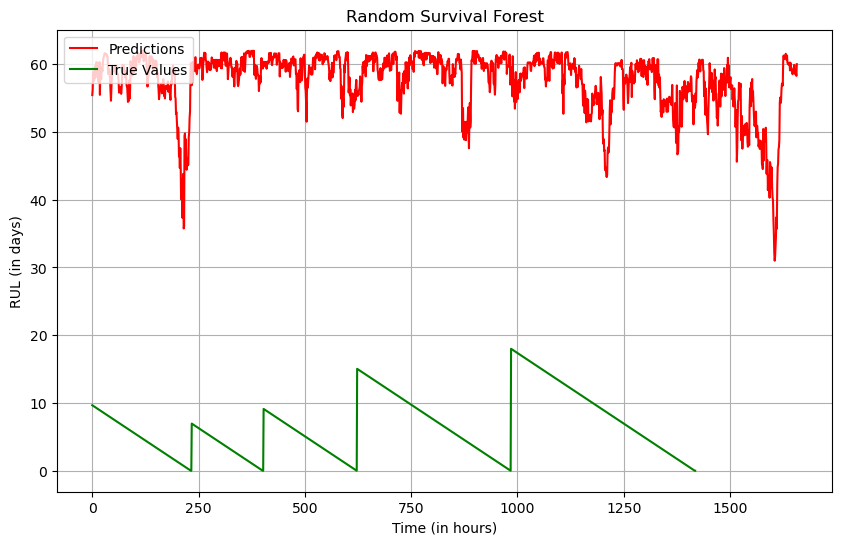

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# plots the 'True_RUL' and the 'Predictions' (which represent the predicted RUL)
plt.figure(figsize=(10, 6))
plt.plot(rul_estimates, label='Predictions', color='red')
plt.plot(True_RUL, label='True Values', color='green')
plt.xlabel('Time (in hours)')
plt.ylabel('RUL (in days)')
plt.title('Random Survival Forest')
plt.legend(loc='upper left')
plt.grid(True)

plt.savefig('RUL_RSF.pdf')

plt.show()


# Testing on Synthetic Data


In [ ]:
import pandas as pd
# reads data to dataframe
synthetic_data = pd.read_csv("synthetic_dataset.csv")
# these synthetic data are already on an hourly basis, so there is no need to aggregate them

synthetic_data['ReadableDate'] = pd.to_datetime(synthetic_data['ReadableDate'])

data = calculate_active_duration(synthetic_data)

# splits data train/val/test: (70/15/15 split)
index_split_date1 = int(len(data) * 0.6)
index_split_date2 = int(len(data) * 0.75)

    # obtains the split dates
split_date1 = data.loc[index_split_date1, "ReadableDate"]
split_date2 = data.loc[index_split_date2, "ReadableDate"]
print(split_date1)
print(split_date2)

    # splits the data into train, validation, and test sets based on the split dates
train_split = data[data["ReadableDate"] < split_date1]
validation_split = data[(data["ReadableDate"] >= split_date1) & (data["ReadableDate"] < split_date2)]
test_split = data[data["ReadableDate"] >= split_date2]


# feature engineering after the split otherwise we have data leakage (via the rolling windows & lags)
final_train = prepare_data(train_split, 5, 5)
final_validation = prepare_data(validation_split, 5, 5)
final_test = prepare_data(test_split, 5, 5)

### Hyperparameter tuning
--> with num_lags = 0 and window_size = 0. These two will be optimized after this optimization (just like we did before)

In [12]:
import numpy as np
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

X_train = final_train.drop(columns=['ReadableDate','Breakdown', 'Active'])  # features for training
Y_train = final_train[['Breakdown', 'Active']]  # event label and  lifetime for training

X_val = final_validation.drop(columns=['ReadableDate', 'Breakdown', 'Active'])  # features for validating
Y_val = final_validation[['Breakdown', 'Active']]  # event label and  lifetime for validating

# converts target (Y) data to structured array (this is needed for the RSF)
Y_train_structured = np.array([(e, t) for e, t in zip(Y_train['Breakdown'], Y_train['Active'])],
                              dtype=[('Breakdown', '?'), ('Active', '<f8')])
Y_val_structured = np.array([(e, t) for e, t in zip(Y_val['Breakdown'], Y_val['Active'])],
                             dtype=[('Breakdown', '?'), ('Active', '<f8')])


# instantiates the Random Survival Forest (RSF) model
rsf = RandomSurvivalForest()

# defines the parameter grid to search
param_grid = {'n_estimators': list(range(50, 401, 10)), 
              'max_features': ['sqrt', 'log2'],
              'min_samples_split': list(range(2, 13)),
              'n_jobs': [-1], 'random_state': [42]}


# creates ParameterGrid object
param_grid = ParameterGrid(param_grid)

# performs the grid search
best_score = float('-inf')
best_params = None
for i, params in enumerate(param_grid, start=1):
    
    # updates the model parameters 
    rsf.set_params(**params)
    
    # fits the model to the training data
    rsf.fit(X_train, Y_train_structured)
    
    # evaluates the model on validation data (by calculating the c-index)
    score = rsf.score(X_val, Y_val_structured)
    

    print(f"Iteration {i}/{len(param_grid)} - Parameters: {params}, Score: {score}")

    # updates best parameters if current score (c-index) is better
    if score > best_score:
        best_score = score
        best_params = params

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Iteration 1/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 42}, Score: 0.5226714557622644
Iteration 2/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 60, 'n_jobs': -1, 'random_state': 42}, Score: 0.5064622091238411
Iteration 3/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 70, 'n_jobs': -1, 'random_state': 42}, Score: 0.5203997052864248
Iteration 4/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 80, 'n_jobs': -1, 'random_state': 42}, Score: 0.526247927795174
Iteration 5/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 90, 'n_jobs': -1, 'random_state': 42}, Score: 0.5324798919383558
Iteration 6/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}, Score: 0.5383434641124824
Iteration 7/792 - Parameters: {'max_feat

In [15]:
X_train = final_train.drop(columns=['ReadableDate','Breakdown', 'Active'])  # features for training
Y_train = final_train[['Breakdown', 'Active']]  # event label and  lifetime for training

X_val = final_validation.drop(columns=['ReadableDate', 'Breakdown', 'Active'])  # features for validating
Y_val = final_validation[['Breakdown', 'Active']]  # event label and lifetimetime for validating

# converts target (Y) data to structured array (this is needed for the RSF)
Y_train_structured = np.array([(e, t) for e, t in zip(Y_train['Breakdown'], Y_train['Active'])],
                              dtype=[('Breakdown', '?'), ('Active', '<f8')])
Y_val_structured = np.array([(e, t) for e, t in zip(Y_val['Breakdown'], Y_val['Active'])],
                             dtype=[('Breakdown', '?'), ('Active', '<f8')])



rsf2 = RandomSurvivalForest(**best_params)
rsf2.fit(X_train, Y_train_structured)

# evaluates the model on validation data (by calculating the c-index)
test_cindex = rsf2.score(X_val, Y_val_structured)


print("\Test Set Performance:")
print("Concordance Index:", test_cindex)

\Test Set Performance:
Concordance Index: 0.8529193926675719


We will optimize the window_size and num_lags in the same way as we did in the original approach

| c-index | window_size |
|-------|-------|
| **0.7916256914566687** | **5** |
| 0.7107713583282115 | 10 |
| 0.6384449907805777 | 15 |
| 0.5933620159803319 | 20 |
| 0.5850491702519975 | 25 |
| 0.6751690227412416 | 30 |
| 0.6078057775046097 | 35 |
| 0.620620774431469 | 40 |
| 0.4959588199139521 | 45 |
| 0.5385064535955747 | 50 |
| 0.48567916410571604 | 55 |
| 0.4811616472034419 | 60 |

| c-index | num_lags |
|-------|-------|
| 0.7916256914566687 | 0 |
| 0.7507990165949601 | 1 |
| 0.7994062634590537 | 2 |
| 0.788710273466371 | 3 |
| 0.8073401566064492 | 4 |
| **0.8529193926675719** | **5** |
| 0.8308001235712079 | 6 |
| 0.826926645225136 | 7 |
| 0.8220388830412978 | 8 |
| 0.8390355770422709 | 9 |
| 0.8295743624744059 | 10 |


--> result (window_size, num_lags) = (5,5)

### Model training and testing

In [16]:
# we combine the train & validation sets, so that the model incorporates as much information as possible.
X_train_final = (pd.concat([final_train, final_validation], ignore_index=True)).drop(columns=['ReadableDate','Breakdown', 'Active']) # Features for validating
Y_train_final = (pd.concat([final_train, final_validation], ignore_index=True))[['Breakdown', 'Active']]  # Event indicator and survival time for validating

X_test = (final_test.drop(columns=['ReadableDate', 'Breakdown', 'Active'])) # Features for validating
Y_test = final_test[['Breakdown', 'Active']]  # Event indicator and survival time for validating

# converts target (Y) data to structured array (this is needed for the RSF)
Y_train_final_structured = np.array([(e, t) for e, t in zip(Y_train_final['Breakdown'], Y_train_final['Active'])],
                              dtype=[('Breakdown', '?'), ('Active', '<f8')])
Y_test_structured = np.array([(e, t) for e, t in zip(Y_test['Breakdown'], Y_test['Active'])],
                              dtype=[('Breakdown', '?'), ('Active', '<f8')])


# trains the model (with best parameters)
RSF = RandomSurvivalForest(**best_params)
RSF.fit(X_train_final, Y_train_final_structured)

# evaluates performance on test set, by computing the c-index
test_cindex = RSF.score(X_test, Y_test_structured)

print("\Test Set Performance:")
print("Concordance Index:", test_cindex)

\Test Set Performance:
Concordance Index: 0.7829610000211153


### Plot (True_RUL vs Predicted_RUL)

In [17]:
import numpy as np

# array of the predicted survival functions of each instance in the test set
survival_probs_array = RSF.predict_survival_function(X_test, return_array=False)
rul_estimates = []

# iterates through each survival function
for survival_function in survival_probs_array:
    # integrates the survival function to compute the RUL (using the Trapezoidal rule)
    rul_estimate = np.trapz(survival_function.y, survival_function.x)
    rul_estimates.append(rul_estimate)

# displays the estimated RUL for each instance in the test set
print("Estimated RUL for each instance in the test set:")
for i, rul in enumerate(rul_estimates):
    print(f"Instance {i}: {rul}")
    



Estimated RUL for each instance in the test set:
Instance 0: 9.208365099406768
Instance 1: 10.071697530864196
Instance 2: 9.543587595532042
Instance 3: 10.439814814814817
Instance 4: 10.994444444444444
Instance 5: 10.73148148148148
Instance 6: 10.507870370370373
Instance 7: 9.446250000000001
Instance 8: 10.19453262786596
Instance 9: 9.34849537037037
Instance 10: 10.442592592592593
Instance 11: 10.67037037037037
Instance 12: 10.809259259259262
Instance 13: 10.816777777777775
Instance 14: 9.617155483405485
Instance 15: 8.561385682219015
Instance 16: 7.442108585858586
Instance 17: 8.23107573753407
Instance 18: 9.154178019168759
Instance 19: 8.562683882475548
Instance 20: 10.229074074074074
Instance 21: 10.31712962962963
Instance 22: 10.799999999999999
Instance 23: 9.553333333333333
Instance 24: 10.491498316498316
Instance 25: 10.88888888888889
Instance 26: 10.57962962962963
Instance 27: 9.59114959114959
Instance 28: 10.192746913580246
Instance 29: 10.068569905403237
Instance 30: 9.7465255

In [18]:
test_result = final_test[["ReadableDate", "Breakdown", "Active"]].copy()
test_result["RUL_prediction"] = rul_estimates

In [19]:
# ReadableDate of each breakdwon in the test set
breakdown_times = test_result[test_result['Breakdown'] == 1]['ReadableDate']

True_RUL = []
# computes the True_RUL
for index, row in test_result.iterrows():
    if not breakdown_times.empty and breakdown_times.iloc[0] == row['ReadableDate']:
        True_RUL.append(0)
        breakdown_times = breakdown_times.drop(breakdown_times.index[0])
    else:
        if not breakdown_times.empty:
            time_until_next_breakdown = (breakdown_times.iloc[0] - row['ReadableDate']).total_seconds() / (3600*24)  # converts seconds to days
            True_RUL.append(time_until_next_breakdown)
        else:
            True_RUL.append(None)  # no more breakdowns after this point (we can't observe the "next" future breakdown)

# adds the True_RUL array tot the dataframe (so we can use this df to plot True_RUL vs predicted RUL)
test_result['True_RUL'] = True_RUL

In [20]:
#test_result.to_excel("/Users/wardmestdagh/Documents/HIRB/THESIS/DOCUMENTEN PURATOS/SENSOR DATA/synthetic_result_RSF.xlsx", index=False)

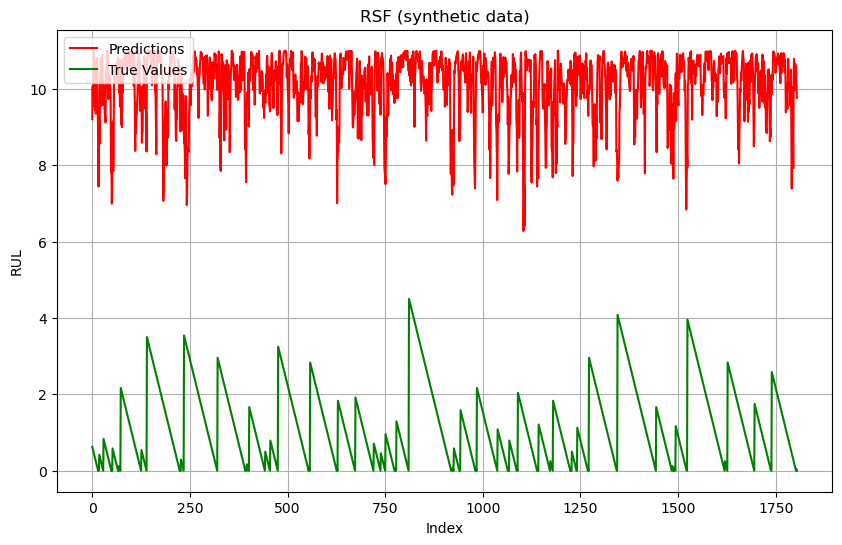

In [21]:
import matplotlib.pyplot as plt
import numpy as np


# plots the 'True_RUL' and the 'Predictions' (which represent the predicted RUL)
plt.figure(figsize=(10, 6))
plt.plot(rul_estimates, label='Predictions', color='red')
plt.plot(True_RUL, label='True Values', color='green')
plt.xlabel('Time (in hours)')
plt.ylabel('RUL (in days)')
plt.title('RSF (synthetic data)')
plt.legend(loc='upper left')
plt.grid(True)

plt.savefig('RUL_RSF.pdf')

plt.show()